In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data
from torch import Tensor
from torch.nn import Module
from torch.optim import AdamW
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from dpt import DepthSense
from util.loss import GeoNetLoss

xFormers not available
xFormers not available


In [3]:
torch.random.manual_seed(7643)

In [4]:
 !nvidia-smi --list-gpus

GPU 0: NVIDIA H100 80GB HBM3 (UUID: GPU-90ea334a-f26b-6ee4-7c10-596006310f6b)


In [5]:
class DepthSenseDataset(Dataset):
    """
    Utility and wrapper for loading datasets.
    """

    def __init__(self, root_dir: str):
        self.root_dir: Path = Path(root_dir)
        self.directories: list[str] = [
            d for d in self.root_dir.iterdir() if d.is_dir()
        ]

    def __getitem__(self, i: int) -> tuple[Tensor, Tensor, Tensor]:
        cur: Path = self.directories[i]
        image: Tensor = torch.from_numpy(np.load(f"{cur}/frame.npy")).float()
        depth: Tensor = torch.from_numpy(np.load(f"{cur}/depth.npy")).float()
        normal: Tensor = torch.from_numpy(np.load(f"{cur}/normal.npy")).float()
        return image, depth, normal

    def __len__(self) -> int:
        return len(self.directories)

In [6]:
from IPython.display import clear_output
# Parameters and hyperparameters used for training.
description: str = "DepthSense for Metric Depth and Normal Estimation"
model_path: str = "models/teacher_{}.pth"

batch_size: int = 4
betas: tuple[float, float] = 0.9, 0.999
dataset_name: Dataset = "hypersim"
decay: float = 1e-2
device: str = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device {device}")
encoder: str = "vits"
epochs: int = 10
eps: float = 1e-8
features: int = 128
lr: float = 1e-4

# Data splitting.
dataset: Dataset = DepthSenseDataset(f"/data/{dataset_name}")
data_size: int = len(dataset)
train_size: int = int(0.8 * data_size)
val_size: int = int(0.1 * data_size)
test_size: int = len(dataset) - train_size - val_size
train_set, val_set, test_set = data.random_split(dataset, [train_size, val_size, test_size])
print(f"data_size: {data_size}, train_size: {train_size}, val_size: {val_size}, test_size: {test_size}")

# Model initialization.
model_name: str = model_path.replace("{}", dataset_name)
model: DepthSense = DepthSense(encoder, features).to(device)
criterion: Module = GeoNetLoss()
optimizer: Optimizer = AdamW(model.parameters(), lr, betas, eps, decay)

Using device cuda
data_size: 18968, train_size: 15174, val_size: 1896, test_size: 1898


In [7]:
import torch.nn as nn

def print_param_summary_by_depth(model: nn.Module, max_depth: int = 1):
    def recurse(module, prefix="", depth=0):
        if depth > max_depth:
            return {}
        
        param_count = sum(p.numel() for p in module.parameters(recurse=True) if p.requires_grad)
        summary = {prefix or "[root]": param_count}
        
        if depth < max_depth:
            for name, child in module.named_children():
                child_name = f"{prefix}.{name}" if prefix else name
                summary.update(recurse(child, prefix=child_name, depth=depth + 1))
        
        return summary

    summary = recurse(model)
    for name, count in summary.items():
        print(f"{name}: {count:,} parameters")
    
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters: {total:,}")

# Example usage:
print_param_summary_by_depth(model, max_depth=2)


[root]: 24,939,492 parameters
pretrained: 21,993,216 parameters
pretrained.patch_embed: 295,296 parameters
pretrained.blocks: 21,302,784 parameters
pretrained.norm: 768 parameters
pretrained.head: 0 parameters
head: 2,946,276 parameters
head.projects: 67,760 parameters
head.resize_layers: 45,168 parameters
head.scratch: 2,630,144 parameters
head.depth_head: 92,289 parameters
head.normal_head: 110,915 parameters

Total trainable parameters: 24,939,492


In [8]:
# OPTIONAL. Model loading, if not training from scratch.
#try:
#    model = torch.load(model_name, weights_only=True)
#except FileNotFoundError:
#    model = DepthSense(encoder, features)

#model.eval()

Epoch 0, iter 50/3794 — Loss: 17.6611


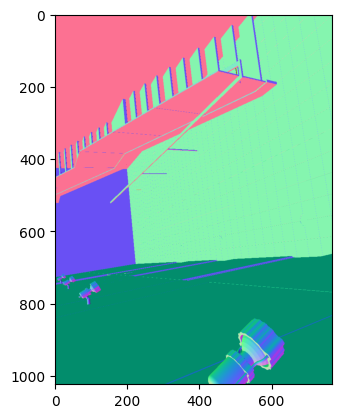

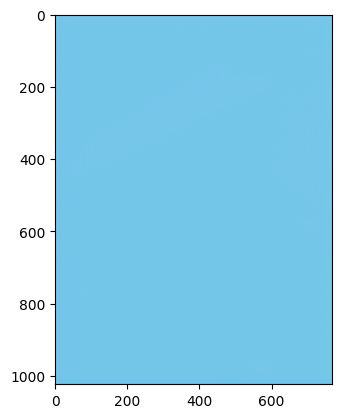

KeyboardInterrupt: 

In [9]:
# Training.
model.train()

train_loader: DataLoader = DataLoader(train_set, batch_size, shuffle=True)
max_iters: int = len(train_loader)
for e in range(epochs):
    print(f"Epoch: {e}/{epochs}...")
    running_loss: float = 0.0
    for i, (x, z_gt, n_gt) in enumerate(train_loader):
        # debug by overfitting to one sample
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
    
        # Move to appropriate device.
        x = x.to(device).permute(0, 3, 1, 2) # (B, H, W, C) → (B, C, H, W)
        z_gt = z_gt.to(device)
        z_gt = torch.clamp(z_gt, min=0.0, max=80.0)
        #z_gt = z_gt / 80
        n_gt = n_gt.to(device).permute(0, 3, 1, 2) # (B, H, W, C) → (B, C, H, W)
        while True:
            i += 1
            #print(f"   [input] x: {x.shape}, z_gt: {z_gt.shape}, n_gt: {n_gt.shape}")
    
            #with torch.autocast(device_type=device, dtype=torch.bfloat16):
            # Forward pass.
            z_hat, n_hat = model(x)
            #print(f"Ground Truth: {z_gt}")
            #z_hat = model(x)
            #print(f"pred: {z_hat}")
            #loss: Tensor = criterion(z_hat, z_gt, n_hat, n_gt)
            loss = criterion(z_hat, z_gt, n_hat, n_gt)
            # Backward pass.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Statistics recollection and display.
            running_loss += loss.item()
            if (i + 1) % 50 == 0 or i == 0:
                avg_loss = running_loss / (i + 1)
                clear_output(wait=True)
                print(f"Epoch {e}, iter {i + 1}/{max_iters} — Loss: {avg_loss:.4f}")
                #plt.imshow(z_gt[0].detach().cpu().numpy().squeeze())
                #plt.show()
                #plt.imshow(z_hat[0].detach().cpu().numpy().squeeze())
                #plt.show()
                plt.imshow((n_gt[0].detach().cpu().numpy().squeeze().T + 1) / 2)
                plt.show()
                plt.imshow((n_hat[0].detach().cpu().numpy().squeeze().T + 1) / 2)
                plt.show()
            #print(f"   [output] z_hat: {z_hat.shape}, n_hat: {n_hat.shape}")
            
            allocated = torch.cuda.memory_allocated() / (1024 ** 3)
            peak = torch.cuda.max_memory_allocated() / (1024 ** 3)
            #print(f"   [CUDA] allocated: {allocated:.2f} GB, peak: {peak:.2f} GB")
        
# Save current model.
torch.save(model.state_dict(), model_name)

In [ ]:
print(model.pretrained.device)

In [ ]:
# Validation.
model.eval()

val_loader: DataLoader = DataLoader(val_set, batch_size, shuffle=True)
max_iters: int = len(val_loader)
running_loss: float = 0.0
for i, (x, z_gt, n_gt) in enumerate(val_loader):
    # Move to appropriate device.
    x = x.to(device)
    z_gt = z_gt.to(device)
    n_gt = n_gt.to(device)
    # Forward pass.
    z, n, z_hat, n_hat = model(x, refine_edges)
    loss: Tensor = criterion(z_hat, z_gt, n_hat, n_gt)
    running_loss += loss.item()

# Statistics recollection and display.
avg_loss: float = running_loss / max_iters
print(f"Validation loss: {avg_loss:.3f}")

In [ ]:
# Pending tasks.

# TODO: Train the teacher and distillate to students.